#### Load required modules

In [2]:
import numpy as np
import logging
import pickle
# required libraries for Reconstructor matrix computation or MPC
from scipy import sparse

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

import os.path
from os import path

from pathlib import Path
# import DOS library
import dos
import dos.plot_tools as ptools

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

sim_folder = 'dos/SHWFS_ES'

In [139]:
# Reload DOS library
import importlib
importlib.reload(dos.tools)


<module 'dos.tools' from '/Users/rromano/Workspace/SIMCEO/dos/tools.py'>

In [14]:
# Reload plot tools library
import importlib
importlib.reload(dos.plot_tools)

<module 'dos.plot_tools' from '/Users/rromano/Workspace/SIMCEO/dos/plot_tools.py'>

#### Compute reconstructor from interacion matrix

In [32]:
# * * * Flag to control if reconstructor matrix is updated * * *
updateReconst = True

# Load calibration data 
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'
dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM.npz', allow_pickle=True)
# Compute SH-WFS consolidated interaction matrix
Dsh = dos.tools.get_SHWFS_D(dt['calibdt'][()]['D'], includeM1S7Rz_col=True)
# Get number of bending modes
n_bm = (Dsh.shape[1] - 82)//7
if((Dsh.shape[1] - 82)%7):
    print('Noninteger result in n_bm computation!')

# Merge SH-WFS and Edge sensor interaction matrix
#alphaBM, alphaEs= 1.0, 1.0 # 1.0/40, 10
#Dm = dos.tools.merge_SH_ES_D(Dsh, dt['calibdt'][()]['De'], alphaBM=alphaBM, alphaEs=alphaEs)
#M = dos.tools.build_TSVD_RecM(Dm,  n_r=12)

M = dos.tools.build_RLS_RecM(Dsh, dt['calibdt'][()]['De'][:,:-6], n_r=32)

# Remove rows relative to BMs
#M[84:,:] = np.zeros((n_bm*7,M.shape[1]))
#M = dos.tools.build_RLS_RecM(Dsh, De=np.empty([0,0]), P=P, rhoP=0*1.0e1, n_r=12)


#M = dos.tools.build_TSVD_RecM(Dsh,  n_r=12)

# Rescale reconstructor based on interaction matrix merge weights
# BMin_weight_vec = np.ones(M.shape[0])
# n_bm, n_es = 46, dt['calibdt'][()]['De'].shape[0]
# BMin_weight_vec[-7*n_bm:] = alphaBM
# s_weight_vec = np.ones(M.shape[1])
# s_weight_vec[-n_es:] = alphaEs
# M = np.dot(np.diag(BMin_weight_vec), M.dot(np.diag(s_weight_vec)))

if (not path.exists(sim_folder+'/ReconstructorM.pickle')) or (updateReconst):    
    Msimceo = dos.tools.gen_recM_4_SIMCEO(M, dt['calibdt'][()]['wfsMask'])
    # Generate SIMCEO reconstructor pickle file
    dos.tools.linear_estimator_2_dos(Msimceo,sim_folder+'/ReconstructorM', B_or_D='D')
    # dos.tools.linear_estimator_2_dos(np.eye(Msimceo.shape[0]),sim_folder+'/ReconstructorM', B_or_D='D')
    print('SH-WFS reconstructor matrix pickle file is updated!')
    print('SIMCEO reconstructor matrix dimensions:', Msimceo.shape)

Consolidated WFS-SH Interaction matrix is 7360 x 404
Regularization term coefficients:
 [3.81674087e-14 5.41685893e-14 5.43083326e-14 5.43285984e-14
 5.45529651e-14 5.46051688e-14 5.47424312e-14 6.83748720e-14
 6.84311232e-14 9.95944722e-14 1.00526998e-13 1.01080329e-13
 1.02288813e-13 1.02648973e-13 1.03959261e-13 1.09249695e-13
 1.09396027e-13 1.10167386e-13 1.10217826e-13 1.11369773e-13
 1.11494251e-13 3.56181005e-13 3.67818114e-13 3.82847291e-13
 5.32168549e-12 5.36579039e-12 2.47329877e-02 1.14171359e-01
 1.14171359e-01 1.14171359e-01 1.14171359e-01 1.00000000e+00]
Reordering SIMCEO reconstructor matrix
SH-WFS reconstructor matrix pickle file is updated!
SIMCEO reconstructor matrix dimensions: (406, 13872)


#### Set initial M1/M2 states and generate respective yaml files

In [128]:
# Python code to set simulation states...

# * * * Flag to control if simulation initial state must be updated * * *
updateX0 = True
#
alignM1S7Rz = False

asec2rad = 4.84814e-6
n_bm = 46
k_states = 0.5
x0 = np.zeros(42+42+7*n_bm)

if (not path.exists(sim_folder+'/M1.yaml')) or (updateX0):
    # M1 random initial values
    x0_M1_Txy = k_states*75.0e-6*(2*np.random.rand(7,2)-1)
    x0_M1_Tz = k_states*np.hstack([160.0e-6*(2*np.random.rand(6)-1),0]).reshape((7, 1))
    x0_M1_Rxy = k_states*0.38*asec2rad*(2*np.random.rand(7,2)-1)
    x0_M1_Rz = k_states*40*asec2rad*(2*np.random.rand(7,1)-1)
    x0_BM = 0.0*k_states*4e-6*(2*np.random.rand(7,n_bm)-1)

#    if(alignM1S7Rz):
#        x0_M1_Rz[-1] = 0
    
    m1_x0_dt = {
        'mirror' : 'M1',
        'mirror_args': {'mirror_modes': 'bending modes', 
                        'N_MODE': n_bm},
        'state': {'Txyz': np.hstack([x0_M1_Txy, x0_M1_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M1_Rxy, x0_M1_Rz]).tolist(),
                  'modes': x0_BM.tolist() }
    }
    # Dump M1 inital state
    with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
else:
    with open(Path(sim_folder)/'M1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)

if (not path.exists(sim_folder+'/M2.yaml')) or (updateX0):        
    # M2 random initial values
    x0_M2_Txy = k_states*75.0e-6*(2*np.random.rand(7,2)-1)
    x0_M2_Tz = k_states*170.0e-6*(2*np.random.rand(7,1)-1)
    x0_M2_Rxy = k_states*3.0*asec2rad*(2*np.random.rand(7,2)-1)
    x0_M2_Rz = k_states*330*asec2rad*(2*np.random.rand(7,1)-1)

    m2_x0_dt = {
        'mirror' : 'M2',
        'mirror_args': {},
        'state': {'Txyz': np.hstack([x0_M2_Txy, x0_M2_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M2_Rxy, x0_M2_Rz]).tolist()}
    }
    # Dump M2 inital state
    with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)
else:
    with open(Path(sim_folder)/'M2.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)

In [11]:
with open(Path(sim_folder)/'wfs48.yaml','r') as stream:
        wfs48_dt = yaml.safe_load(stream)
wfs48_dt['source']['magnitude'] = [6,6,6]
with open(Path(sim_folder)/'wfs48.yaml','w') as f:
        y.dump(wfs48_dt, f)

In [12]:
with open(Path(sim_folder)/'AcO_controller.yaml','r') as stream:
        aco_ctrl_dt = yaml.safe_load(stream)
aco_ctrl_dt['System']['parameters']['num'] = [-0.1]
with open(Path(sim_folder)/'AcO_controller.yaml','w') as f:
        y.dump(aco_ctrl_dt, f)

#### Instantiate DOS

In [33]:
sim = dos.DOS(sim_folder,verbose=logging.INFO,show_timing=2)

INFO:DOS:Reading config from dos/SHWFS_ES/dos.yaml
INFO:DOS:New driver: M1
INFO:M1:New input: Txyz
INFO:M1:New input: Rxyz
INFO:M1:New input: modes
INFO:M1:No inputs!
INFO:DOS:New driver: M2
INFO:M2:New input: Txyz
INFO:M2:New input: Rxyz
INFO:M2:No inputs!
INFO:DOS:New driver: wfs48
INFO:wfs48:No inputs!
INFO:wfs48:New output: data
INFO:wfs48:New output: M12_RBM
INFO:wfs48:Output logged in!
INFO:DOS:New driver: M1_ES
INFO:M1_ES:No inputs!
INFO:M1_ES:New output: deltas
INFO:M1_ES:Output logged in!
INFO:DOS:New driver: ReconstructorM
INFO:ReconstructorM:New input: SH-WFS
INFO:ReconstructorM:New input: edge sensors
INFO:ReconstructorM:New output: x_hat
INFO:ReconstructorM:Output logged in!
INFO:DOS:New driver: AcO_controller
INFO:AcO_controller:New input: x_hat
INFO:AcO_controller:New output: M1 Txyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M1 Rxyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M2 Txyz
INFO:AcO_controller:Output logged 

SIMCEO server received: Acknowledging connection from SIMCEO client!


INFO:DOS:Simulation setup for a duration of 100s @ 1Hz (100 steps)!


In [34]:
# Start simulation
sim._run_()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP0
INFO:M1_ES:EdgeSensors
INFO:science:OP1
INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:M1_ES:None
INFO:science:None
INFO:DOS:Running
INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:M1_ES:EdgeSensors deleted!


Elapsed time: 60.335917711257935


INFO:science:OpticalPath deleted!


In [15]:
sim.pctComplete

100

In [ ]:
sim.push()

In [ ]:
sim.init()

In [ ]:
sim.terminate()

#### Simulation results

In [23]:
sim.logs.entries.keys(), sim.logs
#sim.logs.entries

(dict_keys(['wfs48', 'M1_ES', 'ReconstructorM', 'AcO_controller', 'science']),
 The 'logs' has 14 entries:
  * wfs48
    1. M12_RBM
  * M1_ES
    1. deltas
  * ReconstructorM
    1. x_hat
  * AcO_controller
    1. M1 Txyz
    2. M1 Rxyz
    3. M2 Txyz
    4. M2 Rxyz
    5. M1 BM
  * science
    1. wfe_rms
    2. segment_wfe_rms
    3. PSSn
    4. tiptilt
    5. segment_piston
    6. segment_tiptilt)

In [ ]:
ptools.plot_science(sim.logs.entries['science'],sim.logs.entries['M1_ES'])

Final values:
 WFE: [46.45361074] 
 [0.74194434 0.78010537 0.78583845 0.76204554 0.77797119 0.77803336
 0.17265862] 
PSSn: [0.99986092] 
sum of abs seg piston: 0.28038267130270356 
 [-0.00654335  0.0710915   0.07323137  0.02684784 -0.04015948 -0.05006142
 -0.01244771]


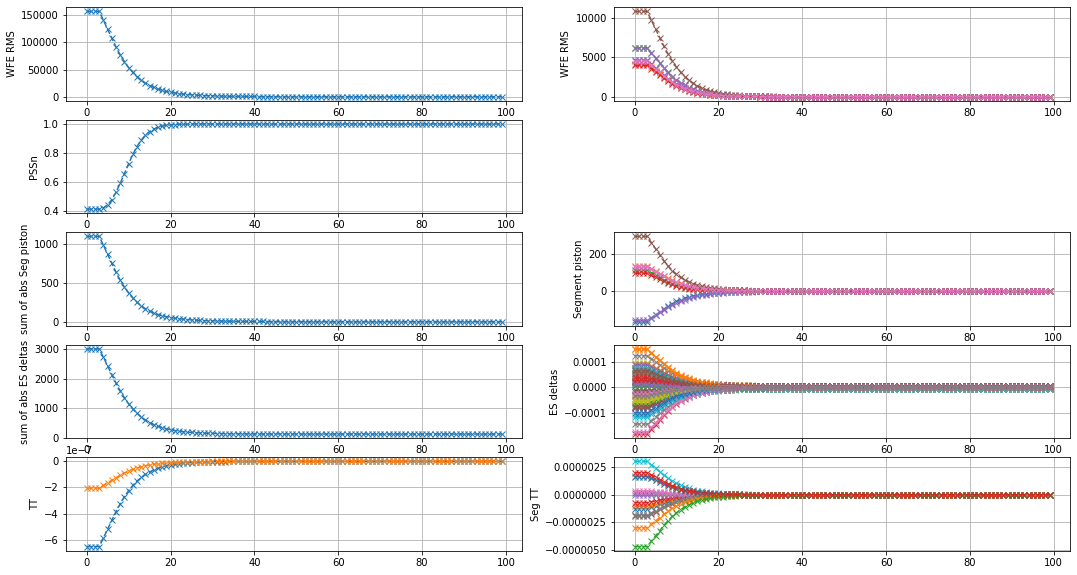

In [131]:
ptools.plot_science(sim.logs.entries['science'],sim.logs.entries['M1_ES'])

#### Control effort

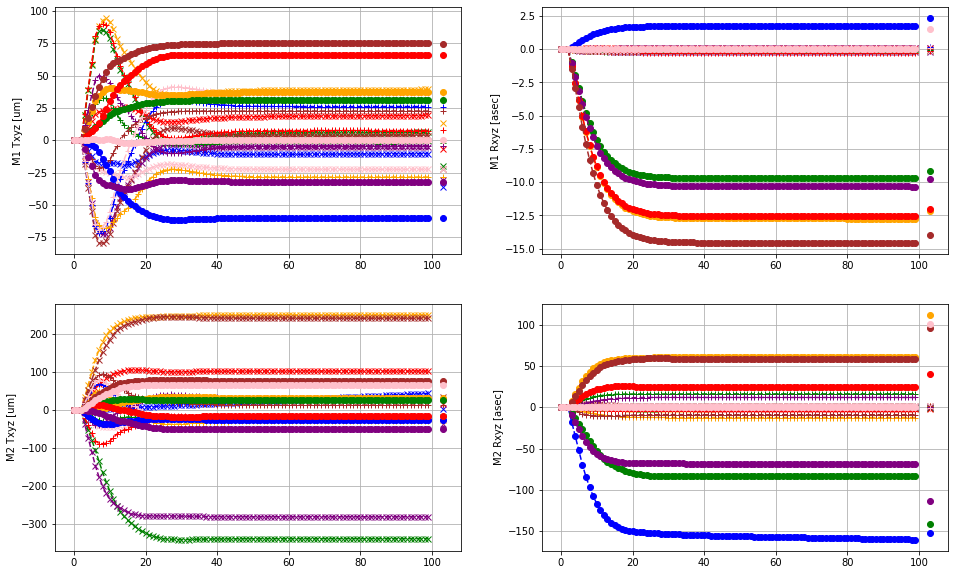

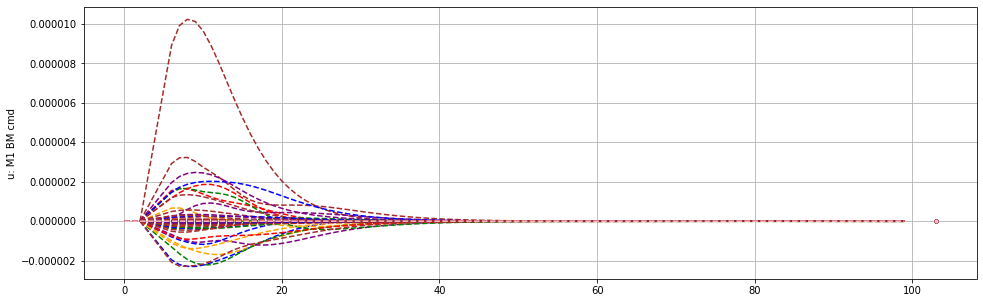

In [132]:
U = sim.logs.entries['AcO_controller']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

In [113]:
import scipy.io
CG2HP = scipy.io.loadmat('../ActiveOptics/CG2HP.mat')

(1, 7)

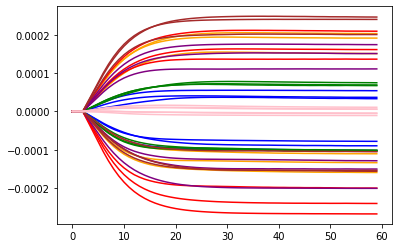

In [164]:
U = sim.logs.entries['AcO_controller']
#CG2HP['CG2HP_d'][0][0].shape

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T, color = colors[kk])


#### Mismatch steady-state

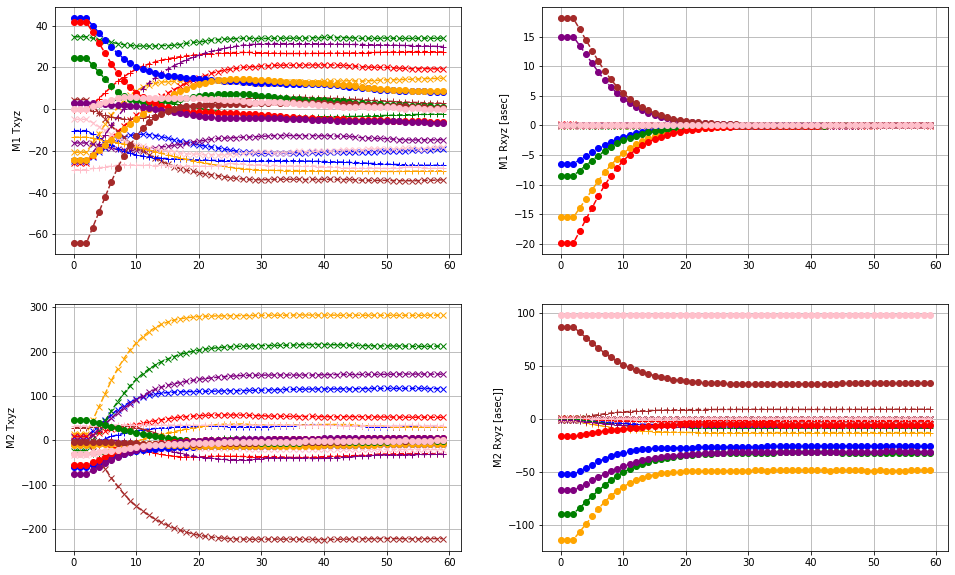

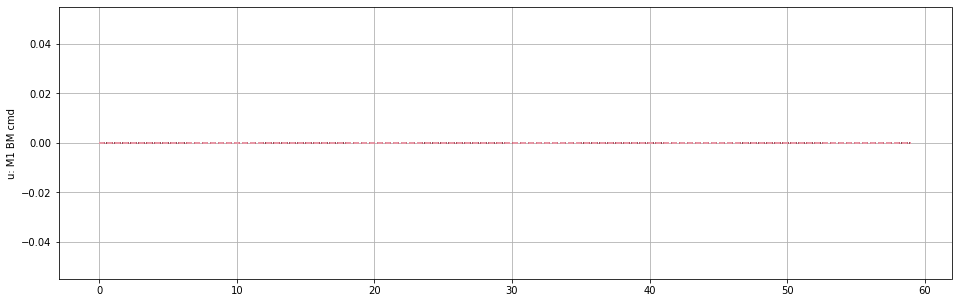

In [22]:
U = sim.logs.entries['AcO_controller']
show_delta = True
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### Reconstructed states

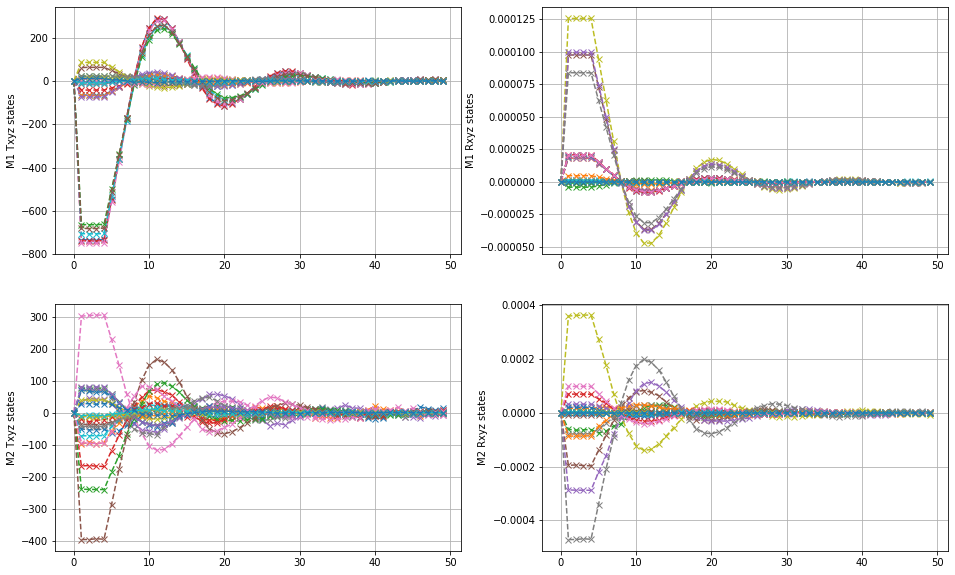

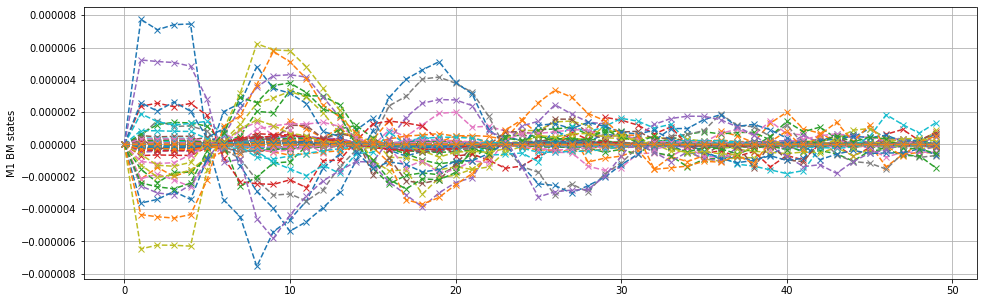

In [141]:
ptools.plot_states(sim.logs.entries['ReconstructorM']['x_hat'].timeSeries, n_bm)

### Baseline estimator results

Final values:
 WFE: [120.32427321] 
 [0.81886836 0.71771394 0.80300083 0.75114082 0.76690837 0.80283319
 0.18549545] 
PSSn: [0.99996617] 
sum of abs seg piston: 0.6568299681930512 
 [-0.05767361  0.15831404  0.03430005 -0.07000634 -0.2547539   0.0568892
 -0.02489283]


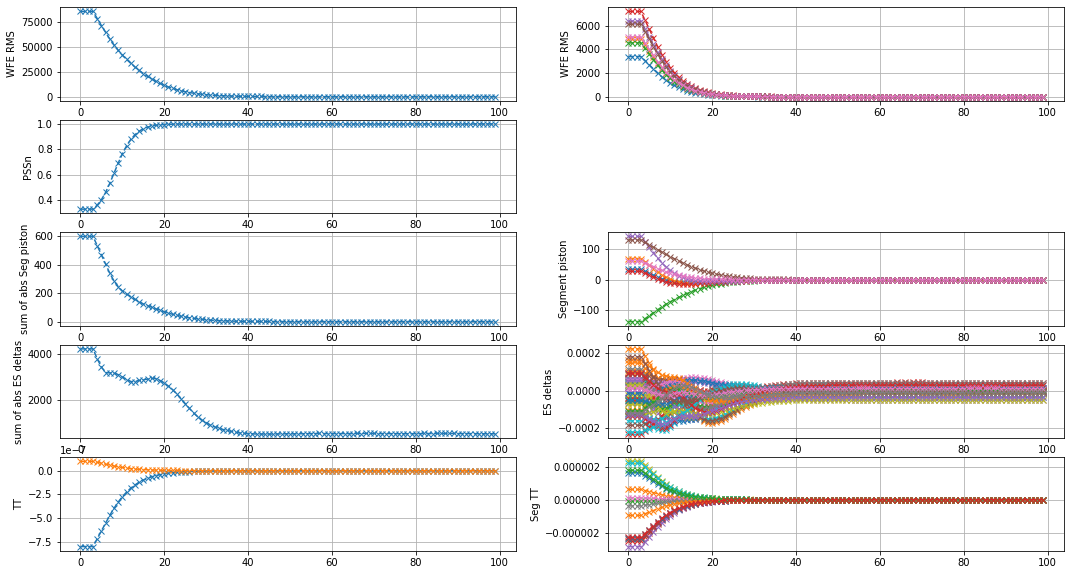

In [69]:
ptools.plot_science(sim.logs.entries['science'],sim.logs.entries['M1_ES'])

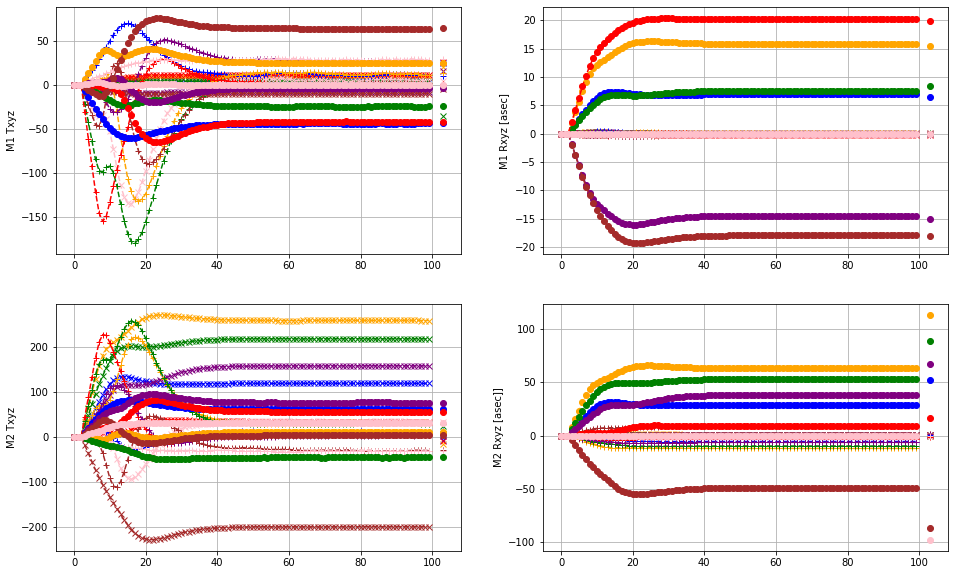

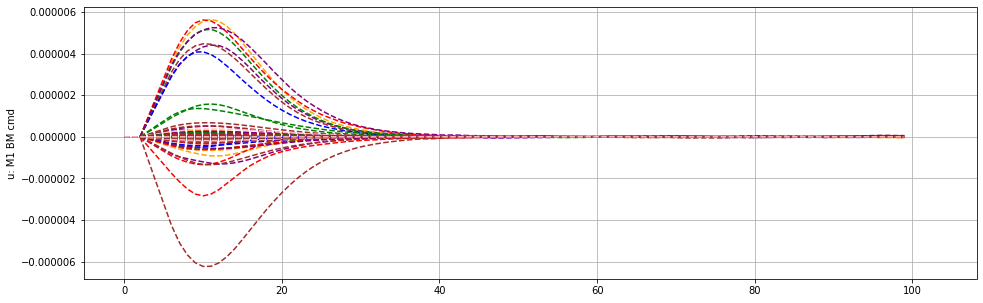

In [70]:
U = sim.logs.entries['AcO_controller']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### Mismatch steady-state

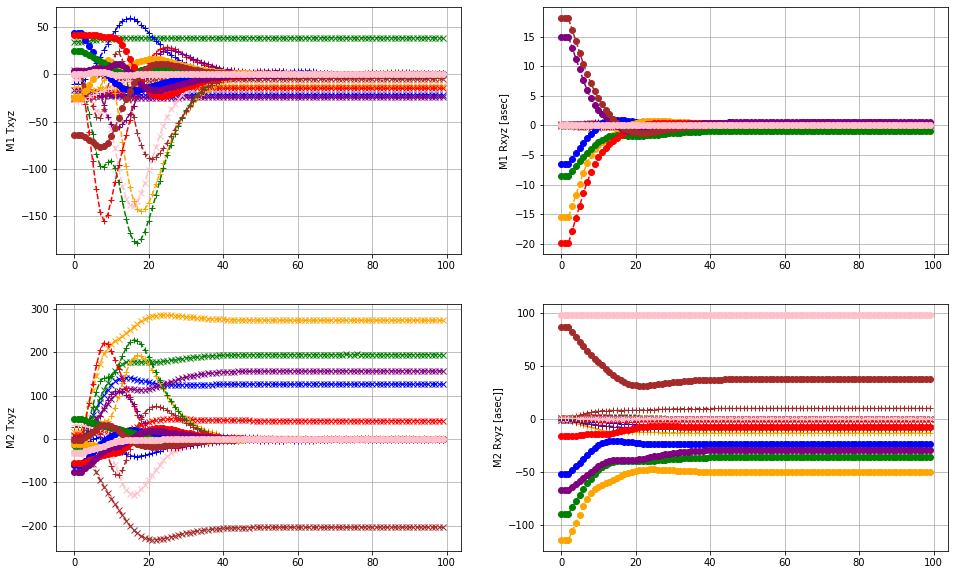

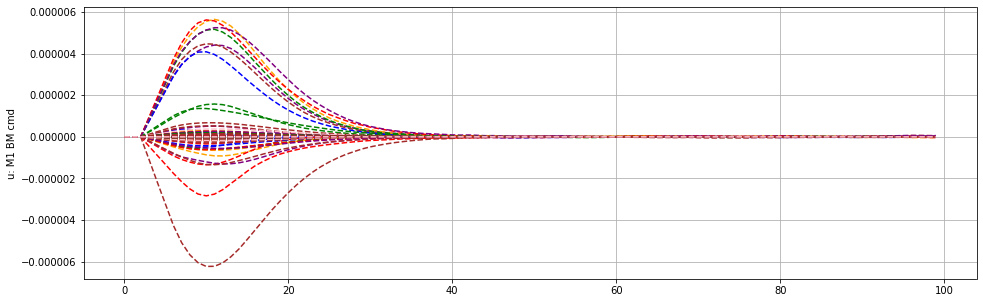

In [71]:
U = sim.logs.entries['AcO_controller']
show_delta = True
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

#### Reconstructed states

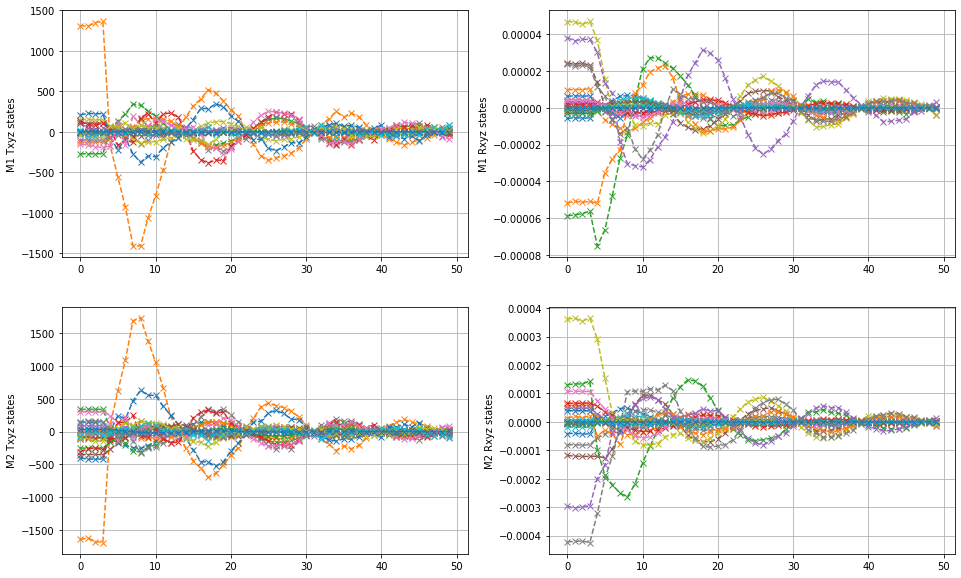

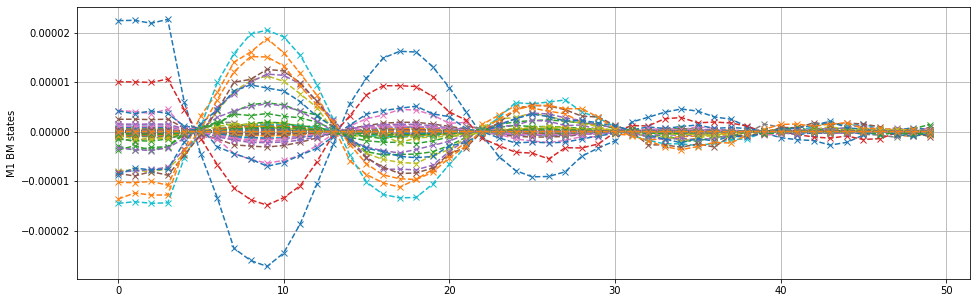

In [48]:
ptools.plot_states(sim.logs.entries['wfs48']['M12_RBM'].timeSeries, n_bm)

### Analysis on the influence of the ES noise and calibrations for S7

In [35]:
#De36wfe = sim.logs.entries['science']['wfe_rms'].timeSeries[1]
#De41wfe = sim.logs.entries['science']['wfe_rms'].timeSeries[1]
#De42wfe = sim.logs.entries['science']['wfe_rms'].timeSeries[1]
#De42wfe_n = sim.logs.entries['science']['wfe_rms'].timeSeries[1]
#De41wfe_n = sim.logs.entries['science']['wfe_rms'].timeSeries[1]
#De36wfe_n = sim.logs.entries['science']['wfe_rms'].timeSeries[1]
De36wfe_n1 = sim.logs.entries['science']['wfe_rms'].timeSeries[1]
#De36wfe_n2 = sim.logs.entries['science']['wfe_rms'].timeSeries[1]

Text(0, 0.5, 'WFE RMS')

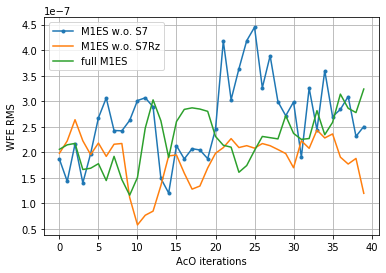

In [39]:
import matplotlib.pyplot as plt
last = 40
#plt.plot(De36wfe[-last:],label='Noiseless M1ES w.o. S7')
#plt.plot(De41wfe[-last:],label='Noiseless M1ES w.o. S7Rz')
#plt.plot(De42wfe[-last:],label='Noiseless full M1ES')
plt.plot(De36wfe_n[-last:],'.-',label='M1ES w.o. S7')
#plt.plot(De36wfe_n1[-last:],'x-',label='M1ES w.o. S7')
#plt.plot(De36wfe_n2[-last:],'+-',label='M1ES w.o. S7')
plt.plot(De41wfe_n[-last:],label='M1ES w.o. S7Rz')
plt.plot(De42wfe_n[-last:],label='full M1ES')
plt.legend()
plt.grid()
plt.xlabel('AcO iterations')
plt.ylabel('WFE RMS')


Mean for 48x36 De: [2.0093039987401086e-08, 4.3495373720503493e-07, 2.722887256112472e-07, 2.786257031317518e-07]
Std dev for 48x36 De: [2.599634588745988e-09, 1.991407871232731e-07, 1.0005854332919207e-07, 1.2839094908648246e-07]
Mean for 48x41 De: [1.4237823253715476e-08, 2.0635474093921857e-07]
Mean for 48x42 De: [1.5063186742381163e-08, 2.13746867672171e-07]


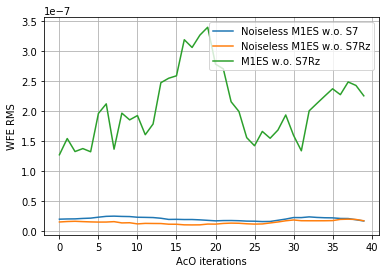

In [117]:
import matplotlib.pyplot as plt
last = 40
#plt.plot(De36wfe[-last:],label='Noiseless M1ES w.o. S7')
plt.plot(De41wfe[-last:],label='Noiseless M1ES w.o. S7Rz')
#plt.plot(De42wfe[-last:],label='Noiseless full M1ES')
#plt.plot(De42wfe_n[-last:],label='M1ES w.o. S7')
#plt.plot(De41wfe_n[-last:],label='M1ES w.o. S7Rz')
#plt.plot(De36wfe_n[-last:],label='full M1ES')
#plt.plot(De36wfe_n1[-last:],'.-',label='full M1ES extra1')
#plt.plot(De36wfe_n2[-last:],'+-',label='full M1ES extra1')
plt.legend()
plt.grid()
plt.xlabel('AcO iterations')
plt.ylabel('WFE RMS')


In [ ]:
# Mean wfe in diferen scenarios
De36_array = [De36wfe, De36wfe_n, De36wfe_n1, De36wfe_n2]
print('Mean for 48x36 De:',[np.mean(De[-last:]) for De in De36_array])
print('Std dev for 48x36 De:',[np.std(De[-last:]) for De in De36_array])
De41_array = [De41wfe, De41wfe_n]
print('Mean for 48x41 De:',[np.mean(De[-last:]) for De in De41_array])
De42_array = [De42wfe, De42wfe_n]
print('Mean for 48x42 De:',[np.mean(De[-last:]) for De in De42_array])